# Подбор персонала

In [125]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(); # более красивый внешний вид графиков по умолчанию


In [126]:
data = pd.read_csv('rabotaru_ru/data/train_public.csv')

In [127]:
data.head(5)

,id,custom_position,operating_schedule_id,description,salary_from,offer_education_id,age_from,age_to,is_agency,is_nonresident,offer_experience_year_count,salary_to,is_male,driving_license,region_id,company_id,city_id,target_prof
0,268842,Подсобный рабочий,1,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,34000,0,NaN,NaN,True,True,1.0,41000.0,True,[],{1783},1234787.0,70,рабочий
1,19090,Разнорабочий,7,<br />\nТребования: <br>На овощную базу в Подм...,66000,0,NaN,NaN,False,False,NaN,NaN,NaN,[],{3},NaN,1,разнорабочий
2,315832,Повар холодного цеха,1,<br />\nТребования: <br>Приготовление салатов....,40000,0,NaN,NaN,False,False,NaN,40000.0,NaN,[],{3},NaN,1,повар
3,365230,Разнорабочий,7,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,35000,0,NaN,NaN,False,True,-100.0,40000.0,NaN,[],{5807},2784163.0,70,разнорабочий
4,154105,Региональный торговый представитель по Смоленс...,1,<strong>Обязанности:</strong><br /> &nbsp;<br ...,30000,4,NaN,NaN,False,True,2.0,70000.0,NaN,[],{362},1703984.0,258,представитель


In [128]:
data.columns

Index(['id', 'custom_position', 'operating_schedule_id', 'description',
       'salary_from', 'offer_education_id', 'age_from', 'age_to', 'is_agency',
       'is_nonresident', 'offer_experience_year_count', 'salary_to', 'is_male',
       'driving_license', 'region_id', 'company_id', 'city_id', 'target_prof'],
      dtype='object')

In [129]:
data.head(1).T

,0
id,268842
custom_position,Подсобный рабочий
operating_schedule_id,1
description,<strong>Обязанности:</strong><br />\r\n<ul>\r\...
salary_from,34000
offer_education_id,0
age_from,NaN
age_to,NaN
is_agency,True
is_nonresident,True


### Описание фичей

  - **id** - Идентификатор вакансии
  - **custom_position** - Название вакансии
  - **operating_schedule_id** - идентификатор графика работы, возможные значения указаны ниже
  - **salary_from** - зарплата от (всегда есть)
  - **salary_to** - потолок зарплаты
  - **description** - текстовое описание вакансии вместе с html тегами и знаками препинания
  - **offer_education_id** - идентификатор образования, расшифровку см. ниже
  - **offer_experience_year_count** - требуемый опыт (лет)
  - **age_from** - минимальный возраст работы
  - **age_to** - максимальный возраст работы
  - **company_id** - идентификатор компании, встречаются вакансии без компаний
  - **city_id** - идентификатор региона размещения (Москва и МО, ), крупные аггломерации
  - **is_agency** - является ли компания агенством
  - **is_nonresident** - доступна ли вакансия для иностранных граждан
  - **is_male** - ищут работников мужского (True), женского (False) пола, в случае пустого значения пол не имеет значения
  - **driving_license** - требуемые категории водительсктх прав
  - **region_id** - города в которых есть офисы компании и куда производится набор сотрудников (Set)
  - **target_prof** - рекомендуемая групповая профессия

In [130]:
# типы данных 
data.dtypes

id                               int64
custom_position                 object
operating_schedule_id            int64
description                     object
salary_from                      int64
offer_education_id               int64
age_from                       float64
age_to                         float64
is_agency                         bool
is_nonresident                    bool
offer_experience_year_count    float64
salary_to                      float64
is_male                         object
driving_license                 object
region_id                       object
company_id                     float64
city_id                          int64
target_prof                     object
dtype: object

In [131]:
# меняем тип некоторых колонок на категориальный
data['operating_schedule_id'] = data['operating_schedule_id'].astype('object')
data['offer_education_id'] = data['offer_education_id'].astype('object')
data['is_male'] = data['is_male'].astype('bool')
data['company_id'] = data['company_id'].astype('object')
data['city_id'] = data['city_id'].astype('object')

In [132]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print('Категориальные признаки: ', categorical_columns)
print('Числовые признаки: ', numerical_columns)

Категориальные признаки:  ['custom_position', 'operating_schedule_id', 'description', 'offer_education_id', 'driving_license', 'region_id', 'company_id', 'city_id', 'target_prof']
Числовые признаки:  ['id', 'salary_from', 'age_from', 'age_to', 'is_agency', 'is_nonresident', 'offer_experience_year_count', 'salary_to', 'is_male']


In [133]:
# кол-во строк (вакансий) и колонок (их признаков)
data.shape

(56297, 18)

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56297 entries, 0 to 56296
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56297 non-null  int64  
 1   custom_position              56297 non-null  object 
 2   operating_schedule_id        56297 non-null  object 
 3   description                  56297 non-null  object 
 4   salary_from                  56297 non-null  int64  
 5   offer_education_id           56297 non-null  object 
 6   age_from                     15798 non-null  float64
 7   age_to                       12931 non-null  float64
 8   is_agency                    56297 non-null  bool   
 9   is_nonresident               56297 non-null  bool   
 10  offer_experience_year_count  38622 non-null  float64
 11  salary_to                    34829 non-null  float64
 12  is_male                      56297 non-null  bool   
 13  driving_license 

In [135]:
# описательная статистика по числоавым признакам
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,56297.0,235876.626019,135901.728858,18.0,118547.0,235786.0,353529.0,471177.0
salary_from,56297.0,38151.308773,86681.631959,-1.0,20000.0,35000.0,53000.0,19002500.0
age_from,15798.0,20.425434,4.056352,14.0,18.0,18.0,22.0,60.0
age_to,12931.0,53.606604,12.556347,22.0,45.0,52.0,60.0,99.0
offer_experience_year_count,38622.0,-34.882140,48.606458,-100.0,-100.0,0.0,1.0,10.0
salary_to,34829.0,46912.823423,111741.706222,-1.0,20000.0,40000.0,65000.0,19002500.0


In [136]:
# описательная статистика по категориальным признакам
data[categorical_columns].describe().T

,count,unique,top,freq
custom_position,56297,14345,Грузчик,981
operating_schedule_id,56297,6,1,27010
description,56297,41692,<br />\nТребования: <br> <br />\nИнформация о ...,293
offer_education_id,56297,5,0,47394
driving_license,56297,16,[],54806
region_id,56297,1486,{3},18167
company_id,42499.0,10218.0,1234787.0,2040.0
city_id,56297,67,1,16144
target_prof,56297,521,водитель,4885


## Исследование признаков

### рекомендуемая групповая профессия (целевая переменная)

In [137]:
# сколько уникальных групповых профессий ?
data['target_prof'].nunique()

521

In [138]:
data['target_prof'].unique()[:10]

array(['рабочий', 'разнорабочий', 'повар', 'представитель', 'слесарь',
       'специалист', 'электромонтер', 'колорист', 'водитель',
       'администратор'], dtype=object)

In [139]:
# статистика распределения профессий (в абсолютных значениях)
data['target_prof'].value_counts()

водитель      4885
продавец      3360
менеджер      2399
повар         2284
грузчик       2137
              ... 
измеритель       1
сушильщик        1
торцовщик        1
гидравлист       1
шихтовщик        1
Name: target_prof, Length: 521, dtype: int64

In [140]:
# статистика распределения профессий (в относительных долях)
data['target_prof'].value_counts(normalize = True)

водитель      0.086772
продавец      0.059683
менеджер      0.042613
повар         0.040571
грузчик       0.037959
                ...   
измеритель    0.000018
сушильщик     0.000018
торцовщик     0.000018
гидравлист    0.000018
шихтовщик     0.000018
Name: target_prof, Length: 521, dtype: float64

In [141]:
#data['target_prof'].hist()

## Визуализация

In [142]:
#sns.pairplot(data)

In [143]:
# матрица корреляций
data.corr()

,id,salary_from,age_from,age_to,is_agency,is_nonresident,offer_experience_year_count,salary_to,is_male
id,1.000000,0.000573,0.009224,-0.150269,-0.048694,0.048434,-0.029145,0.010016,-0.021733
salary_from,0.000573,1.000000,0.207308,0.000840,0.046251,0.049817,0.166805,0.966633,0.016187
age_from,0.009224,0.207308,1.000000,-0.107405,-0.006695,-0.002874,0.422167,0.092278,-0.222600
age_to,-0.150269,0.000840,-0.107405,1.000000,-0.017456,0.184849,-0.230461,-0.026269,0.156960
is_agency,-0.048694,0.046251,-0.006695,-0.017456,1.000000,0.066788,0.008550,0.044461,0.014770
is_nonresident,0.048434,0.049817,-0.002874,0.184849,0.066788,1.000000,0.079616,0.065214,-0.061705
offer_experience_year_count,-0.029145,0.166805,0.422167,-0.230461,0.008550,0.079616,1.000000,0.059082,0.025210
salary_to,0.010016,0.966633,0.092278,-0.026269,0.044461,0.065214,0.059082,1.000000,0.008329
is_male,-0.021733,0.016187,-0.222600,0.156960,0.014770,-0.061705,0.025210,0.008329,1.000000


In [144]:
#sns.heatmap(data[numerical_columns])

## Преобразование признаков

In [145]:
data[categorical_columns].describe().T

,count,unique,top,freq
custom_position,56297,14345,Грузчик,981
operating_schedule_id,56297,6,1,27010
description,56297,41692,<br />\nТребования: <br> <br />\nИнформация о ...,293
offer_education_id,56297,5,0,47394
driving_license,56297,16,[],54806
region_id,56297,1486,{3},18167
company_id,42499.0,10218.0,1234787.0,2040.0
city_id,56297,67,1,16144
target_prof,56297,521,водитель,4885


## Предобработка данных

In [146]:
data['operating_schedule_id'].value_counts()

1    27010
3    12861
7    11368
2     2943
5     1432
6      683
Name: operating_schedule_id, dtype: int64

### Удаление выбросов в числовых полях (salary_from, salary_to)

In [147]:
data['salary_from'].describe()

count    5.629700e+04
mean     3.815131e+04
std      8.668163e+04
min     -1.000000e+00
25%      2.000000e+04
50%      3.500000e+04
75%      5.300000e+04
max      1.900250e+07
Name: salary_from, dtype: float64

In [148]:
data['salary_from'].count()

56297

<AxesSubplot:>

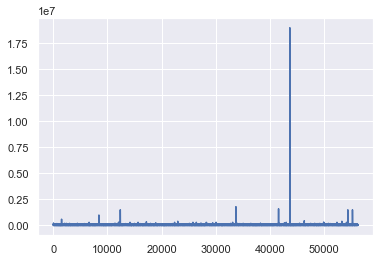

In [149]:
data['salary_from'].plot()

In [150]:
max(data['salary_from'])

19002500

In [151]:
z_scores = scipy.stats.zscore(data['salary_from'])
abs_z_scores  = np.abs(z_scores)

#outliers_indeces = data['salary_from'][abs_z_scores > 4].index
#data.iloc[ outliers_indeces ]
#outliers_indeces.remove(46401)

#len(data.drop(data['salary_from'][abs_z_scores > 4].index))
data.drop(data['salary_from'][abs_z_scores > 4].index, inplace=True)

In [152]:
print(data['salary_to'].count())
data['salary_to'].describe()

34824


count    3.482400e+04
mean     4.615565e+04
std      4.157114e+04
min     -1.000000e+00
25%      2.000000e+04
50%      4.000000e+04
75%      6.500000e+04
max      1.150000e+06
Name: salary_to, dtype: float64

<AxesSubplot:>

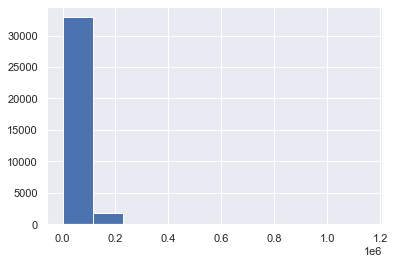

In [153]:
data['salary_to'].hist()

In [154]:
# удаляем строку с максимальной salary_to - это единственный выброс в этом поле
#data['salary_to'].quantile(0.9)
#data[ data['salary_to'] == data['salary_to'].max() ]

data.drop( data[data['salary_to'] == data['salary_to'].max()].index, inplace=True)

In [155]:
data.drop( data[data['salary_to'] == -1].index, inplace=True)

In [156]:
# значения salary_to == 0 заменяем на salary_from
sf = data[data['salary_to'] == 0]['salary_from']
data.loc[data['salary_to'] == 0]['salary_to'] = sf

<ipython-input-156-1f2c58dc836d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['salary_to'] == 0]['salary_to'] = sf


In [157]:
data.drop( data[data['salary_to'] == 0].index, inplace=True)

### Заполнение пропущенных значений

In [189]:
data.count(axis=0)

id                             48805
custom_position                48805
operating_schedule_id          48805
description                    48805
salary_from                    48805
offer_education_id             48805
age_from                       48805
age_to                         48805
is_agency                      48805
is_nonresident                 48805
offer_experience_year_count    34800
salary_to                      48805
is_male                        48805
driving_license                48805
region_id                      48805
company_id                     38736
city_id                        48805
target_prof                    48805
dtype: int64

In [160]:
# для записей, где не указана верхняя планка зарплаты, берём значение из нижней планки
data['salary_to'].fillna(data['salary_from'], axis=0, inplace=True)

In [169]:
data['age_from'].describe()

count    14796.000000
mean        20.371317
std          4.013680
min         14.000000
25%         18.000000
50%         18.000000
75%         21.000000
max         60.000000
Name: age_from, dtype: float64

In [170]:
data['age_from'].mode()

0    18.0
dtype: float64

<AxesSubplot:>

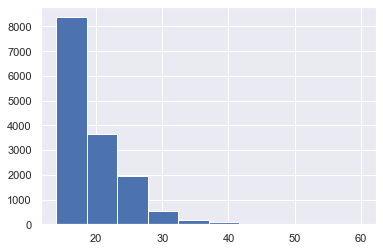

In [168]:
data['age_from'].hist()

In [181]:
# "возраст от" заменяем на моду (наиболее часто встречающееся значение)
data['age_from'].fillna(int(data['age_from'].mode()), axis=0, inplace=True)

In [183]:
data['age_to'].describe()
#data['age_to'].hist()

count    12013.000000
mean        53.610422
std         12.547986
min         22.000000
25%         45.000000
50%         52.000000
75%         60.000000
max         99.000000
Name: age_to, dtype: float64

In [188]:
# "возраст до" заменяем на среднее значение
data['age_to'].fillna(data['age_to'].mean(axis=0), axis=0, inplace=True)

In [191]:
data['offer_experience_year_count'].describe()

count    34800.000000
mean       -36.160489
std         48.943320
min       -100.000000
25%       -100.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: offer_experience_year_count, dtype: float64

<AxesSubplot:>

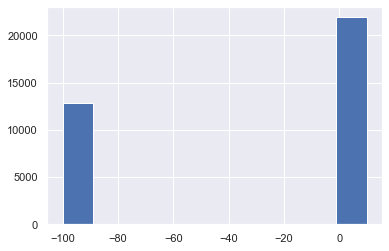

In [192]:
data['offer_experience_year_count'].hist()

In [194]:
len(data[ data['offer_experience_year_count'] < 0 ])

16324

## Нормализация числовых данных

## Векторизация категориальных признаков

## Построение классификатора

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.67, 
                                                    random_state=42)
